**Труфанов Вадим, ИУ5-63,Рубежный контроль №2**

**Задание №1, собстсвенно выбранный датасет**

# Задание:
**Классификация текстов на основе методов наивного Байеса.**

Необходимо решить задачу классификации текстов на основе любого выбранного датасета (кроме примера, который рассматривался в лекции). Классификация может быть бинарной или многоклассовой. Целевой признак из выбранного датасета может иметь любой физический смысл, примером является задача анализа тональности текста.

Необходимо сформировать признаки на основе CountVectorizer или TfidfVectorizer.

В качестве классификаторов необходимо использовать два классификатора, не относящихся к наивным Байесовским методам (например, LogisticRegression, LinearSVC), а также Multinomial Naive Bayes (MNB), Complement Naive Bayes (CNB), Bernoulli Naive Bayes.

Для каждого метода необходимо оценить качество классификации с помощью хотя бы одной метрики качества классификации (например, Accuracy).

Сделать выводы о том, какой классификатор осуществляет более качественную классификацию на Вашем наборе данных.

# Решение задания:

# 1. Импорт библиотек и данных

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/freud-detection/Freud_Detection_Train.csv
/kaggle/input/freud-detection/Freud_Detection_Test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")
plt.rcParams['figure.dpi']= 150

In [3]:
# Импорт датасета
freud_test = pd.read_csv('/kaggle/input/freud-detection/Freud_Detection_Test.csv', sep=",")
freud_train = pd.read_csv('/kaggle/input/freud-detection/Freud_Detection_Train.csv', sep=",")

# 2. Характеристики датасета
Для решения задачи текстовой классификации был выбран нестандартный датасет *Freud Detection* (не стоит путать с распространненымы датасетами *Fraud Detection*, которые используется для обнаружения мошеннических операций). Выбранный датасет содержит 160 цитат 4 авторов:
Зигумнда Фрейда, Джейн Остин, Марка Твена и Майи Энжделоу. Датасет уже разбит на тестовый и обучающий набор в соотношении 1:3 по цитатам каждого автора.

**Датасет содержит следующие признаки:**

    quote - цитата автора
    author - фамилия автора цитаты
    freud - булевый флаг, является ли Фрейд автором цитаты

На данном датасете будет решаться две задачи:
1. Бинарная классификация по Фрейду
2. Многоклассовая классификация по всем авторам.

In [4]:
# Первые 5 строк датасета
freud_train.head()

,quote,author,freud
0,"One day, in retrospect, the years of struggle ...",Freud,1
1,Being entirely honest with oneself is a good e...,Freud,1
2,Unexpressed emotions will never die. They are ...,Freud,1
3,"Most people do not really want freedom, becaus...",Freud,1
4,We are never so defenseless against suffering ...,Freud,1


In [5]:
# Первые 5 строк датасета
freud_test.head()

,quote,author,freud
0,"America is a mistake, a giant mistake.",Freud,1
1,The intention that man should be happy is not ...,Freud,1
2,My love is something valuable to me which I ou...,Freud,1
3,Men are more moral than they think and far mor...,Freud,1
4,A man should not strive to eliminate his compl...,Freud,1


# 3. Обработка признаков и данных

Сначала перемешаем строки в датасете, так как цитаты идут по порядку по каждому из авторов.

In [6]:
# Перемешиваем строки тестовой выборки
freud_test = freud_test.sample(frac=1,random_state=42).reset_index(drop=True)
freud_test.head()

,quote,author,freud
0,"I come here with no expectations, only to prof...",Austen,0
1,"There are people, who the more you do for them...",Austen,0
2,"I wish, as well as everybody else, to be perfe...",Austen,0
3,Give every day the chance to become the most b...,Twain,0
4,A man should not strive to eliminate his compl...,Freud,1


In [7]:
# Перемешиваем строки обучающей выборки
freud_train = freud_train.sample(frac=1,random_state=42).reset_index(drop=True)
freud_train.head()

,quote,author,freud
0,There is a stubbornness about me that never ca...,Austen,0
1,"Ah! There is nothing like staying at home, for...",Austen,0
2,We are never so defenseless against suffering ...,Freud,1
3,My idea of good company...is the company of cl...,Austen,0
4,The virtuous man contents himself with dreamin...,Freud,1


Выведем гистаграммы распределей цитат по авторам.

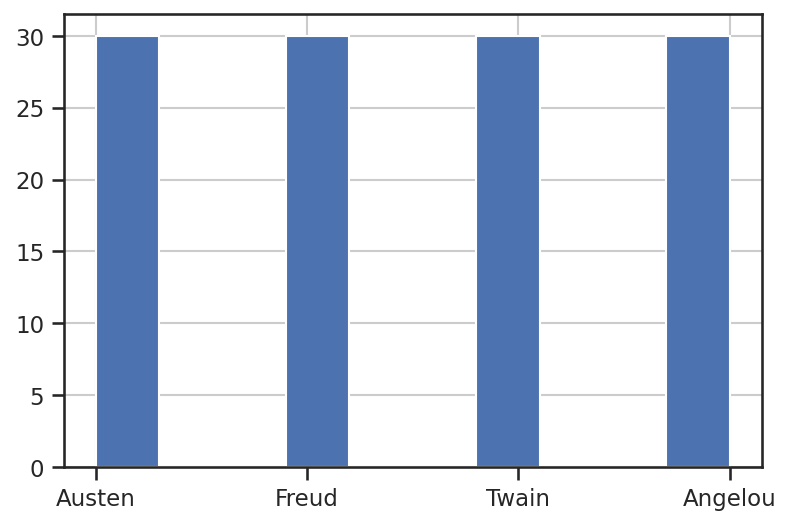

In [8]:
# Гистограмма цитат по авторам в обучающей выборки
freud_train['author'].hist()

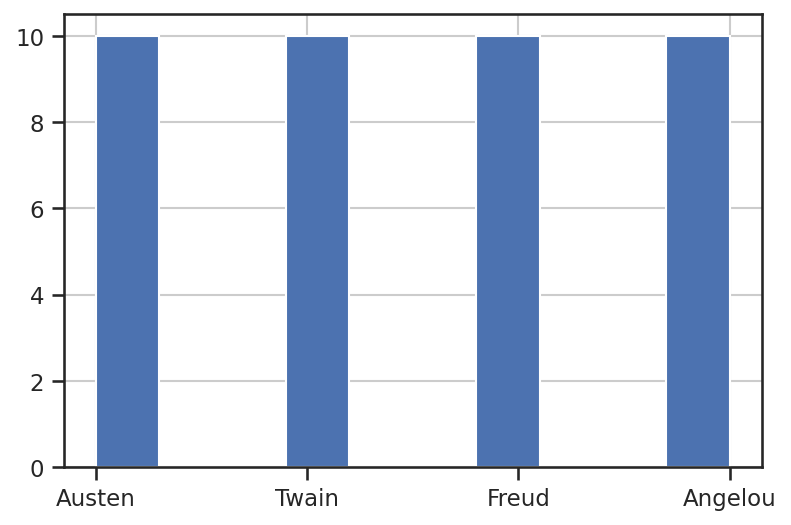

In [9]:
# Гистограмма цитат по авторам в тестовой выборки
freud_test['author'].hist()

Как видно из гистограмм, цитат поровну у каждого из авторов : по 30 в обучающей выборке и по 10 в тестовой.

# 4. Выбор целевого признака
В качестве целевого признака выбраны признаки:
1. *freud* - для бинарной классификации
2. *author* - для мультиклассовой классификации

Чтобы использовать признак *author* для построения моделей преобразуем его в количественный.

In [10]:
# Импорт трансформатора из библиотеки
from sklearn.preprocessing import LabelEncoder

In [11]:
# Обучение трансформатора на классах обучающей выборки
le = LabelEncoder()
le.fit(freud_train['author'].unique())
le.classes_

array(['Angelou', 'Austen', 'Freud', 'Twain'], dtype=object)

In [12]:
# Применение трансформатора для кодирования целевого признака author
freud_train['author'] = le.transform(freud_train['author'])
freud_test['author'] = le.transform(freud_test['author'])
freud_test.head(),freud_train.head()

(                                               quote  author  freud
 0  I come here with no expectations, only to prof...       1      0
 1  There are people, who the more you do for them...       1      0
 2  I wish, as well as everybody else, to be perfe...       1      0
 3  Give every day the chance to become the most b...       3      0
 4  A man should not strive to eliminate his compl...       2      1,
                                                quote  author  freud
 0  There is a stubbornness about me that never ca...       1      0
 1  Ah! There is nothing like staying at home, for...       1      0
 2  We are never so defenseless against suffering ...       2      1
 3  My idea of good company...is the company of cl...       1      0
 4  The virtuous man contents himself with dreamin...       2      1)

# 5. Предобработка данных
Для предобработки данных используется библиотека nltk.

Она применяется для следующих задач:

1. С помощью нее цитаты разбиваются на слова токенизатором, используя **sent_tokenize** для разбиения на предложения и **wordpunct_tokenize** для разбиения на слова(токены)
2. С помощью pos_tag каждому токену присваивается часть речи
3. **WordNetLemmatizer** использует токен и информацию о части речи, чтобы провести лемматизацию
4. Также для отбора слов применяется опционально список стоп слов **sw.words('english')** для английского языка

In [13]:
# Импорт векторизаторов из библиотеки
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [14]:
# Импорт метрики из библиотеки
from sklearn.metrics import accuracy_score

In [16]:
# Класс предобработки данных для разбиения предложений на слова и формирования лемм

import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.base import BaseEstimator, TransformerMixin

class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, document):
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If stopword, ignore token and continue
                if self.stopwords and token in self.stopwords:
                    continue

                # If punctuation, ignore token and continue
                if all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)


In [17]:
# Пример работы предобработчитка на первых 5 цитатах тренировочной выборки 
preprocessor = NLTKPreprocessor()
lemmas = preprocessor.fit_transform(freud_train['quote'][0:5])
for lemma,quote in zip(lemmas,freud_train['quote'][0:5]):
    print('Цитата: ',quote)
    print('Леммы: '+','.join(lemma))

Цитата:  There is a stubbornness about me that never can bear to be frightened at the will of others. My courage always rises at every attempt to intimidate me.
Леммы: there,be,a,stubbornness,about,me,that,never,can,bear,to,be,frighten,at,the,will,of,others,my,courage,always,rise,at,every,attempt,to,intimidate,me
Цитата:  Ah! There is nothing like staying at home, for real comfort.
Леммы: ah,there,be,nothing,like,stay,at,home,for,real,comfort
Цитата:  We are never so defenseless against suffering as when we love.
Леммы: we,be,never,so,defenseless,against,suffer,a,when,we,love
Цитата:  My idea of good company...is the company of clever, well-informed people, who have a great deal of conversation; that is what I call good company.
Леммы: my,idea,of,good,company,be,the,company,of,clever,well,informed,people,who,have,a,great,deal,of,conversation,that,be,what,i,call,good,company
Цитата:  The virtuous man contents himself with dreaming that which the wicked man does in actual life.
Леммы: th

# 6. Построение пайплайна и решетчатый поиск по параметрам
Чтобы выбрать наилучшую модель используется **пайплайн** состоящий из:
1. Предобработчика данных (опционально) NLTKPreprocessor
2. Векторизатора CountVectorizer или TfidfVectorizer
3. Классификатора из списка ниже:

**Классифакаторы**

    DecisionTreeClassifier
    LogisticRegression
    LinearSVC
    MultinomialNB
    СomplementNB
    BernoulliNB

Для **сетки параметров** используется:
1. стоп-слова для предобработчика
2. стоп-слова для векторизатора
3. разное число н-грамм для векторизатора

В качестве **метрики** используется:
1. Ф1-мера для бинарной классификации
2. accuracy для мультиклассовой классификации

Данные разделяются на 4 фолда.

In [18]:
# Функции для осуществления решетчатого поиска по пайплайну и его параметрам

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report as clsr
from sklearn.model_selection import GridSearchCV
import time

def timeit(func):
    """
    Simple timing decorator
    """
    def wrapper(*args, **kwargs):
        start  = time.time()
        result = func(*args, **kwargs)
        delta  = time.time() - start
        return result, delta
    return wrapper


def identity(arg):
    """
    Simple identity function works as a passthrough.
    """
    return arg


def build_and_evaluate(X_train, X_test, y_train, y_test, 
                       classifier, classifier_params, cv, scoring,target_names,binary=False):
 
    @timeit
    def build(X_train, y_train, classifier, classifier_params, cv, scoring, binary):
        """
        Inner build function that builds a single model.
        """
        if isinstance(classifier, type):
            classifier = classifier()

        preprocessor = NLTKPreprocessor()
        count_vect = CountVectorizer(binary=binary)
        tfidf_vect = TfidfVectorizer(binary=binary)
        count_vect_simple = CountVectorizer(tokenizer=identity,preprocessor=None, lowercase=False,binary=binary)
        tfidf_vect_simple = TfidfVectorizer(tokenizer=identity,preprocessor=None, lowercase=False,binary=binary)
        
        pipe_params_grid = [{
        'preprocessor':[None],    
        'vectorizer':[count_vect, tfidf_vect],
        'vectorizer__stop_words': [None,sw.words('english')],
        'vectorizer__ngram_range': [(1,1),(1,2),(1,3),(2,3)]
        },
        {
        'preprocessor':[preprocessor],
        'preprocessor__stopwords': [None,set(sw.words('english'))],
        'vectorizer':[count_vect_simple, 
                      tfidf_vect_simple],
        'vectorizer__ngram_range': [(1,1),(1,2),(1,3),(2,3)]
        }]
            
        classifier_params = ({'classifier__'+k: v for k, v in classifier_params.items()})
        #print(classifier_params)
        for combination in pipe_params_grid:
            combination.update(classifier_params)
        #print(pipe_params_grid)
        pipeline = Pipeline([
            ('preprocessor', None),
            ('vectorizer', None),
            ('classifier', classifier),
        ])

        gs_pipeline = GridSearchCV(pipeline, pipe_params_grid, cv=cv, scoring=scoring,verbose=1,n_jobs=1)
        gs_pipeline.fit(X_train, y_train)
        
        #display('Gris Search - результаты:')
        # Выводим результаты подбора
        #print("Результаты подбора: ",gs_pipeline.cv_results_)
        # Лучшая модель
        display('Лучшая из построенных моделей:')
        print("Лучшая модель: ",gs_pipeline.best_estimator_)
        # Лучшее значение метрики
        print("Лучшее значение метрики: ",gs_pipeline.best_score_)
        # Лучшее значение параметров
        print("Лучшее значение параметров: ",gs_pipeline.best_params_)
        
        return gs_pipeline.best_estimator_
    
    best_model, secs = build(X_train, y_train, classifier, classifier_params, cv, scoring,binary)

    print("Evaluation model fit in {:0.3f} seconds".format(secs))
    print("Classification Report:\n")

    y_pred = best_model.predict(X_test)
    print(clsr(y_test, y_pred, target_names=target_names))
    return best_model


In [19]:
# Формирование списков с метками классов
binary_names=['not freud','freud']
multiclass_names=le.classes_.tolist()
binary_names,multiclass_names

(['not freud', 'freud'], ['Angelou', 'Austen', 'Freud', 'Twain'])

In [20]:
# Импорты моделей из библиотеки
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB

In [21]:
# Гиперпараметры решающего дерева для решетчатого поиска
dtc_param_grid = {
    'max_depth': [5, 6],
    'min_samples_leaf': [5,10],
    'max_features': [0.5, None]
}

In [22]:
# Гиперпараметры логистической регрессии для решетчатого поиска
lr_param_grid = {'C': [1, 5, 10, 100]}

In [23]:
# Гиперпараметры линейной машины опорных векторов для решетчатого поиска
svc_param_grid = {'C': [1, 5, 10, 100]}

In [24]:
# Пустые гиперпараметры для решетчатого поиска
empty_param_grid = {}

In [25]:
# Словарь моделей
classifiers = [{'model_name':'DecisionTreeClassifier','classifier':DecisionTreeClassifier,'param_grid':dtc_param_grid},
               {'model_name':'LogisticRegression','classifier':LogisticRegression,'param_grid':lr_param_grid},
               {'model_name':'LinearSVC','classifier':LinearSVC,'param_grid':svc_param_grid},
               {'model_name':'MultinomialNB','classifier':MultinomialNB,'param_grid':empty_param_grid},
               {'model_name':'ComplementNB','classifier':ComplementNB,'param_grid':empty_param_grid},
               {'model_name':'BernoulliNB','classifier':BernoulliNB,'param_grid':empty_param_grid},]

In [26]:
# Функция для осуществления решетчатого поиска по всем моделям в цикле
def build_models(X_colname,y_colname,target_names,scoring):
    best_models = []
    for classifier in classifiers:
        binary_features = True if classifier['model_name']=='BernoulliNB' else False
        display('============'+classifier['model_name']+'============')
        best_model = build_and_evaluate(freud_train[X_colname],freud_test[X_colname],freud_train[y_colname],freud_test[y_colname],
                           classifier['classifier'],classifier['param_grid'],cv=4,scoring=scoring,
                           target_names=target_names,binary=binary_features)
        print(best_model)
        best_models.append({'model_name':classifier['model_name'],'best_model': best_model})
    return best_models

In [27]:
# Поиск лучших моделей для бинарной классификации
best_binary_models = build_models('quote','freud',binary_names,'f1')

'============DecisionTreeClassifier============'

Fitting 4 folds for each of 256 candidates, totalling 1024 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1024 out of 1024 | elapsed:  1.8min finished


'Лучшая из построенных моделей:'

Лучшая модель:  Pipeline(steps=[('preprocessor',
                 NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(',
                                         ')', '*', '+', ',', '-', '.', '/', ':',
                                         ';', '<', '=', '>', '?', '@', '[',
                                         '\\', ']', '^', '_', '`', '{', '|', ...})),
                ('vectorizer',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 2),
                                 tokenizer=<function identity at 0x7f906d52d8c0>)),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=10))])
Лучшее значение метрики:  0.39880952380952384
Лучшее значение параметров:  {'classifier__max_depth': 5, 'classifier__max_features': None, 'classifier__min_samples_leaf': 10, 'preprocessor': NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
                        ',', '-', '.', '/', ':', ';', '<', '=', '>

'============LogisticRegression============'

Fitting 4 folds for each of 128 candidates, totalling 512 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:   58.6s finished


'Лучшая из построенных моделей:'

Лучшая модель:  Pipeline(steps=[('preprocessor', None), ('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression(C=100))])
Лучшее значение метрики:  0.38636363636363635
Лучшее значение параметров:  {'classifier__C': 100, 'preprocessor': None, 'vectorizer': TfidfVectorizer(), 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': None}
Evaluation model fit in 58.689 seconds
Classification Report:

              precision    recall  f1-score   support

   not freud       0.78      0.93      0.85        30
       freud       0.50      0.20      0.29        10

    accuracy                           0.75        40
   macro avg       0.64      0.57      0.57        40
weighted avg       0.71      0.75      0.71        40

Pipeline(steps=[('preprocessor', None), ('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression(C=100))])


'============LinearSVC============'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 128 candidates, totalling 512 fits


[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:   52.2s finished


'Лучшая из построенных моделей:'

Лучшая модель:  Pipeline(steps=[('preprocessor',
                 NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(',
                                         ')', '*', '+', ',', '-', '.', '/', ':',
                                         ';', '<', '=', '>', '?', '@', '[',
                                         '\\', ']', '^', '_', '`', '{', '|', ...})),
                ('vectorizer',
                 TfidfVectorizer(lowercase=False,
                                 tokenizer=<function identity at 0x7f906d52d8c0>)),
                ('classifier', LinearSVC(C=10))])
Лучшее значение метрики:  0.42948717948717946
Лучшее значение параметров:  {'classifier__C': 10, 'preprocessor': NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
                        ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`', '{', '|', ...}), 'preprocessor__stopwords': None, 'vectorizer': TfidfVectorizer(lowerca

'============MultinomialNB============'

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:   13.0s finished


'Лучшая из построенных моделей:'

Лучшая модель:  Pipeline(steps=[('preprocessor', None),
                ('vectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('classifier', MultinomialNB())])
Лучшее значение метрики:  0.3138888888888889
Лучшее значение параметров:  {'preprocessor': None, 'vectorizer': CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you'r

'============ComplementNB============'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:   12.9s finished


'Лучшая из построенных моделей:'

Лучшая модель:  Pipeline(steps=[('preprocessor',
                 NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(',
                                         ')', '*', '+', ',', '-', '.', '/', ':',
                                         ';', '<', '=', '>', '?', '@', '[',
                                         '\\', ']', '^', '_', '`', '{', '|', ...})),
                ('vectorizer',
                 TfidfVectorizer(lowercase=False, ngram_range=(2, 3),
                                 tokenizer=<function identity at 0x7f906d52d8c0>)),
                ('classifier', ComplementNB())])
Лучшее значение метрики:  0.4452380952380952
Лучшее значение параметров:  {'preprocessor': NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
                        ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`', '{', '|', ...}), 'preprocessor__stopwords': None, 'vectorizer': TfidfVectorizer(lowercase=

'============BernoulliNB============'

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:   12.8s finished


'Лучшая из построенных моделей:'

Лучшая модель:  Pipeline(steps=[('preprocessor', None),
                ('vectorizer', CountVectorizer(binary=True)),
                ('classifier', BernoulliNB())])
Лучшее значение метрики:  0.0
Лучшее значение параметров:  {'preprocessor': None, 'vectorizer': CountVectorizer(binary=True), 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': None}
Evaluation model fit in 12.805 seconds
Classification Report:

              precision    recall  f1-score   support

   not freud       0.75      1.00      0.86        30
       freud       0.00      0.00      0.00        10

    accuracy                           0.75        40
   macro avg       0.38      0.50      0.43        40
weighted avg       0.56      0.75      0.64        40

Pipeline(steps=[('preprocessor', None),
                ('vectorizer', CountVectorizer(binary=True)),
                ('classifier', BernoulliNB())])


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# Поиск лучших моделей для мультиклассовой классификации
best_multi_models = build_models('quote','author',multiclass_names,'accuracy')

'============DecisionTreeClassifier============'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 256 candidates, totalling 1024 fits


[Parallel(n_jobs=1)]: Done 1024 out of 1024 | elapsed:  1.7min finished


'Лучшая из построенных моделей:'

Лучшая модель:  Pipeline(steps=[('preprocessor',
                 NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(',
                                         ')', '*', '+', ',', '-', '.', '/', ':',
                                         ';', '<', '=', '>', '?', '@', '[',
                                         '\\', ']', '^', '_', '`', '{', '|', ...})),
                ('vectorizer',
                 CountVectorizer(lowercase=False, ngram_range=(1, 2),
                                 tokenizer=<function identity at 0x7f906d52d8c0>)),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, max_features=0.5,
                                        min_samples_leaf=5))])
Лучшее значение метрики:  0.4916666666666667
Лучшее значение параметров:  {'classifier__max_depth': 5, 'classifier__max_features': 0.5, 'classifier__min_samples_leaf': 5, 'preprocessor': NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
            

'============LogisticRegression============'

Fitting 4 folds for each of 128 candidates, totalling 512 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:  1.2min finished


'Лучшая из построенных моделей:'

Лучшая модель:  Pipeline(steps=[('preprocessor',
                 NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(',
                                         ')', '*', '+', ',', '-', '.', '/', ':',
                                         ';', '<', '=', '>', '?', '@', '[',
                                         '\\', ']', '^', '_', '`', '{', '|', ...})),
                ('vectorizer',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 3),
                                 tokenizer=<function identity at 0x7f906d52d8c0>)),
                ('classifier', LogisticRegression(C=5))])
Лучшее значение метрики:  0.5166666666666666
Лучшее значение параметров:  {'classifier__C': 5, 'preprocessor': NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
                        ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`', '{', '|', ...}), 'preprocessor__stopwords': None, 'vectorizer

'============LinearSVC============'

Fitting 4 folds for each of 128 candidates, totalling 512 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:   57.2s finished


'Лучшая из построенных моделей:'

Лучшая модель:  Pipeline(steps=[('preprocessor',
                 NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(',
                                         ')', '*', '+', ',', '-', '.', '/', ':',
                                         ';', '<', '=', '>', '?', '@', '[',
                                         '\\', ']', '^', '_', '`', '{', '|', ...})),
                ('vectorizer',
                 TfidfVectorizer(lowercase=False, ngram_range=(2, 3),
                                 tokenizer=<function identity at 0x7f906d52d8c0>)),
                ('classifier', LinearSVC(C=10))])
Лучшее значение метрики:  0.5249999999999999
Лучшее значение параметров:  {'classifier__C': 10, 'preprocessor': NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
                        ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`', '{', '|', ...}), 'preprocessor__stopwords': None, 'vectorizer': Tfid

'============MultinomialNB============'

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:   12.6s finished


'Лучшая из построенных моделей:'

Лучшая модель:  Pipeline(steps=[('preprocessor',
                 NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(',
                                         ')', '*', '+', ',', '-', '.', '/', ':',
                                         ';', '<', '=', '>', '?', '@', '[',
                                         '\\', ']', '^', '_', '`', '{', '|', ...})),
                ('vectorizer',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 2),
                                 tokenizer=<function identity at 0x7f906d52d8c0>)),
                ('classifier', MultinomialNB())])
Лучшее значение метрики:  0.48333333333333334
Лучшее значение параметров:  {'preprocessor': NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
                        ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`', '{', '|', ...}), 'preprocessor__stopwords': None, 'vectorizer': TfidfVectorizer(lowercas

'============ComplementNB============'

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:   12.6s finished


'Лучшая из построенных моделей:'

Лучшая модель:  Pipeline(steps=[('preprocessor',
                 NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(',
                                         ')', '*', '+', ',', '-', '.', '/', ':',
                                         ';', '<', '=', '>', '?', '@', '[',
                                         '\\', ']', '^', '_', '`', '{', '|', ...})),
                ('vectorizer',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 2),
                                 tokenizer=<function identity at 0x7f906d52d8c0>)),
                ('classifier', ComplementNB())])
Лучшее значение метрики:  0.525
Лучшее значение параметров:  {'preprocessor': NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
                        ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`', '{', '|', ...}), 'preprocessor__stopwords': None, 'vectorizer': TfidfVectorizer(lowercase=False, ngram_

'============BernoulliNB============'

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:   13.1s finished


'Лучшая из построенных моделей:'

Лучшая модель:  Pipeline(steps=[('preprocessor',
                 NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(',
                                         ')', '*', '+', ',', '-', '.', '/', ':',
                                         ';', '<', '=', '>', '?', '@', '[',
                                         '\\', ']', '^', '_', '`', '{', '|', ...})),
                ('vectorizer',
                 CountVectorizer(binary=True, lowercase=False,
                                 tokenizer=<function identity at 0x7f906d52d8c0>)),
                ('classifier', BernoulliNB())])
Лучшее значение метрики:  0.45
Лучшее значение параметров:  {'preprocessor': NLTKPreprocessor(punct={'!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
                        ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`', '{', '|', ...}), 'preprocessor__stopwords': None, 'vectorizer': CountVectorizer(binary=True, lowercase=False,
  

# 7. Сравнение моделей
Для сравнения лучших моделей используется метрика accuracy, которая применяется как для всего целевого признака, так и по каждому классу отдельно.

Реализованы функции вывода этой метрики для сравнения моделей.

In [30]:
from typing import Dict
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    for i in accs:
        print('accuracy, класс {}: {}'.format(i, accs[i]))
    return accs

In [31]:
# Вывод значения accuracy для тестового набора и классов
def print_accuracy_scores(y_train,y_test, predict_y_test,target_names):
    # Качество для тестового набора
    test_score = accuracy_score(y_test, predict_y_test)
    print('accuracy, тестовая выборка: ', test_score)
    accuracy_scores = {}
    accuracy_scores['accuracy'] = test_score
    accs = accuracy_score_for_classes(y_test, predict_y_test)
    class_accuracy = dict(zip(target_names, list(accs.values())))
    for i in class_accuracy:
        print('accuracy, класс {}: {}'.format(i, class_accuracy[i]))
    accuracy_scores.update(class_accuracy)
    return accuracy_scores
        
# Обучение модели и вычисление целевого признака
def fit_predict(estimator, X_train, X_test, y_train):
    estimator.fit(X_train, y_train)
    target_test = estimator.predict(X_test)
    return target_test
# Рассчет accuracy для модели
def print_model_accuracy(estimator, X_col, y_col,target_names):
    X_train = freud_train[X_col]
    X_test = freud_test[X_col]
    y_train = freud_train[y_col]
    y_test = freud_test[y_col]
    target_test = fit_predict(estimator,X_train,X_test,y_train)
    accuracy_scores = print_accuracy_scores(y_train,y_test,target_test,target_names)
    return accuracy_scores

In [32]:
# Функция получения accuracy для перечня моделей
def print_models_accuracy(X_col,y_col,target_names,best_models):
    model_stats = []
    for model in best_models:
        print(model['model_name'])
        accuracy_scores = print_model_accuracy(model['best_model'],X_col,y_col,target_names)
        model_stat = {}
        model_stat['model_name']=model['model_name']
        model_stat.update({str(key): value for key, value in accuracy_scores.items()})
        model_stats.append(model_stat)
    return model_stats

In [33]:
# Получение accuracy для лучших моделей бинарной классификации
binary_model_stats = print_models_accuracy('quote','freud',binary_names,best_binary_models)
#model_stats

DecisionTreeClassifier
accuracy, тестовая выборка:  0.75
accuracy, класс not freud: 0.9333333333333333
accuracy, класс freud: 0.2
LogisticRegression
accuracy, тестовая выборка:  0.75
accuracy, класс not freud: 0.9333333333333333
accuracy, класс freud: 0.2
LinearSVC
accuracy, тестовая выборка:  0.8
accuracy, класс not freud: 0.9333333333333333
accuracy, класс freud: 0.4
MultinomialNB
accuracy, тестовая выборка:  0.725
accuracy, класс not freud: 0.9333333333333333
accuracy, класс freud: 0.1
ComplementNB
accuracy, тестовая выборка:  0.775
accuracy, класс not freud: 0.9333333333333333
accuracy, класс freud: 0.3
BernoulliNB
accuracy, тестовая выборка:  0.75
accuracy, класс not freud: 1.0
accuracy, класс freud: 0.0


In [34]:
#Функция соединения словарей в один, значения каждого ключа в виде листов
def dict_zip(*dicts):
    return {k: [d[k] for d in dicts] for k in dicts[0].keys()}

In [39]:
# Вывод графиков для сравнения моделей
def print_models_plots(*stats):
    zip_model_data = dict_zip(*stats)
    df = pd.DataFrame(zip_model_data,index=zip_model_data['model_name'])
    display(df)
    df_plot = df.transpose().drop('model_name')
    # Выводим отдельные диаграммы для каждой оценки
    ax = df_plot.iloc[0,:].plot(kind='barh',title=df_plot.index.values[0],figsize=(4,4))
    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(0, i.get_y()+0.2, \
        str(round(i.get_width(), 4)), fontsize=8, color='white',weight = 'bold')
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    
    ax = df_plot.iloc[1:,:].plot(kind='bar',figsize=(10,6),width=0.6)
    # set individual bar lables using above list
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x(), i.get_height()+0.001, \
                str(round(i.get_height()*0.9, 2)), fontsize=5,
                color='#323232',weight = 'bold')
    ax.legend(bbox_to_anchor=(1.1, 1.05))

# 8. Анализ моделей
Сравним модели используя таблицы и столбчатые диаграммы.

# 8.1 Бинарная классификация

,model_name,accuracy,not freud,freud
DecisionTreeClassifier,DecisionTreeClassifier,0.750,0.933333,0.2
LogisticRegression,LogisticRegression,0.750,0.933333,0.2
LinearSVC,LinearSVC,0.800,0.933333,0.4
MultinomialNB,MultinomialNB,0.725,0.933333,0.1
ComplementNB,ComplementNB,0.775,0.933333,0.3
BernoulliNB,BernoulliNB,0.750,1.000000,0.0


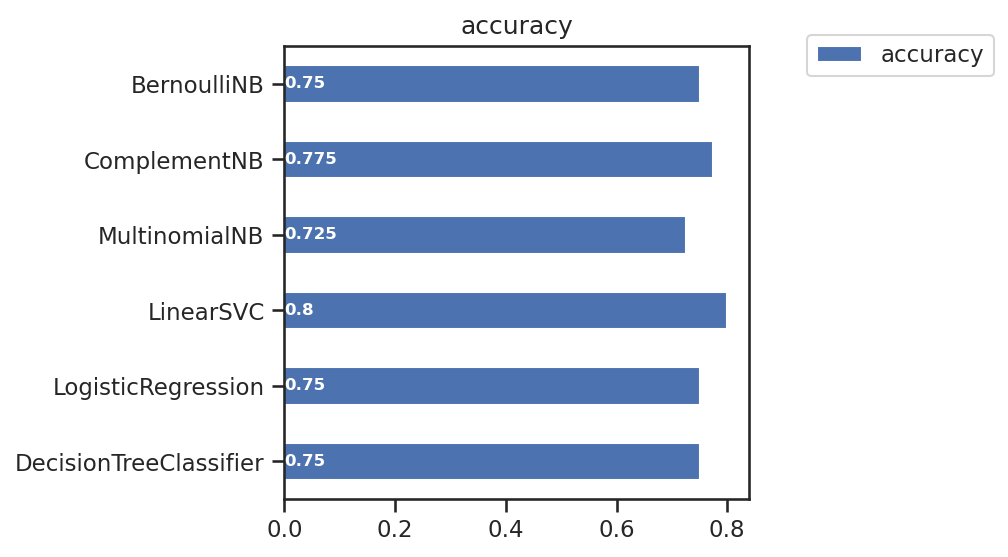

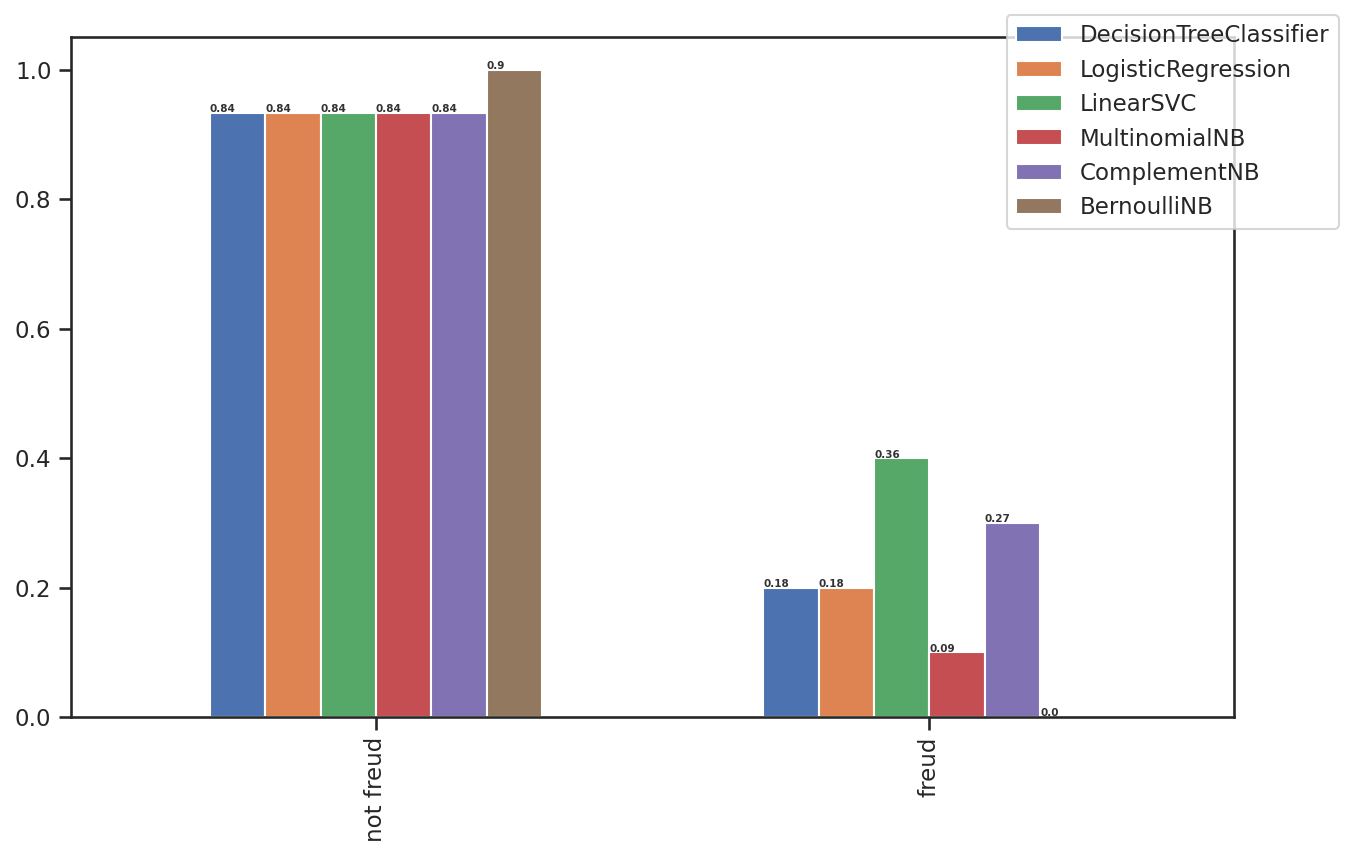

In [40]:
# Графики сранения accuracy для лучших моделей бинарной классификации
print_models_plots(*binary_model_stats)

Как видно из таблицы и диаграмм все модели достаточно хорошо определяют цитаты, которые не относятся к Фрейду. Однако, его настоящие цитаты все модели предсказали плохо, что свидетельствует о дисбалансе выборки и том, что моделям не хватило данных для правильной идентификации цитат психолога.

Лучше всего показатель на настоящих цитатах у модели LinearSVC, метрика составляет значение 0.36, что все равно очень мало.

Посмотрим, как справились классификаторы на равномерно распределенных цитатах по авторам.

# 8.2 Многоклассовая классификация

In [41]:
# Получение accuracy для лучших моделей мультиклассовой классификации
multi_model_stats = print_models_accuracy('quote','author',multiclass_names,best_multi_models)
#model_stats

DecisionTreeClassifier
accuracy, тестовая выборка:  0.4
accuracy, класс Angelou: 0.2
accuracy, класс Austen: 0.5
accuracy, класс Freud: 0.8
accuracy, класс Twain: 0.1
LogisticRegression
accuracy, тестовая выборка:  0.45
accuracy, класс Angelou: 0.3
accuracy, класс Austen: 0.6
accuracy, класс Freud: 0.5
accuracy, класс Twain: 0.4
LinearSVC
accuracy, тестовая выборка:  0.5
accuracy, класс Angelou: 0.4
accuracy, класс Austen: 0.8
accuracy, класс Freud: 0.5
accuracy, класс Twain: 0.3
MultinomialNB
accuracy, тестовая выборка:  0.425
accuracy, класс Angelou: 0.4
accuracy, класс Austen: 0.8
accuracy, класс Freud: 0.4
accuracy, класс Twain: 0.1
ComplementNB
accuracy, тестовая выборка:  0.45
accuracy, класс Angelou: 0.4
accuracy, класс Austen: 0.8
accuracy, класс Freud: 0.4
accuracy, класс Twain: 0.2
BernoulliNB
accuracy, тестовая выборка:  0.425
accuracy, класс Angelou: 0.3
accuracy, класс Austen: 0.4
accuracy, класс Freud: 0.2
accuracy, класс Twain: 0.8


,model_name,accuracy,Angelou,Austen,Freud,Twain
DecisionTreeClassifier,DecisionTreeClassifier,0.400,0.2,0.5,0.8,0.1
LogisticRegression,LogisticRegression,0.450,0.3,0.6,0.5,0.4
LinearSVC,LinearSVC,0.500,0.4,0.8,0.5,0.3
MultinomialNB,MultinomialNB,0.425,0.4,0.8,0.4,0.1
ComplementNB,ComplementNB,0.450,0.4,0.8,0.4,0.2
BernoulliNB,BernoulliNB,0.425,0.3,0.4,0.2,0.8


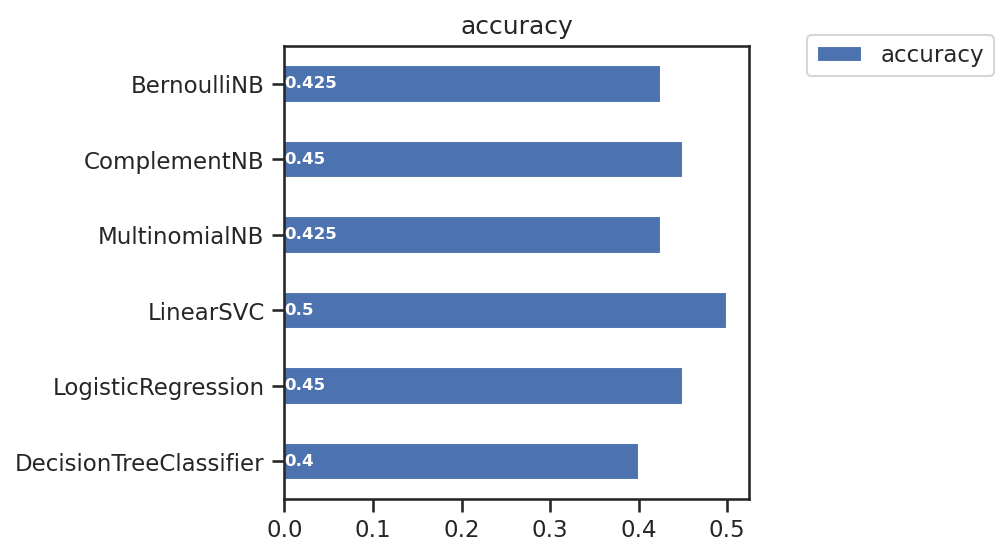

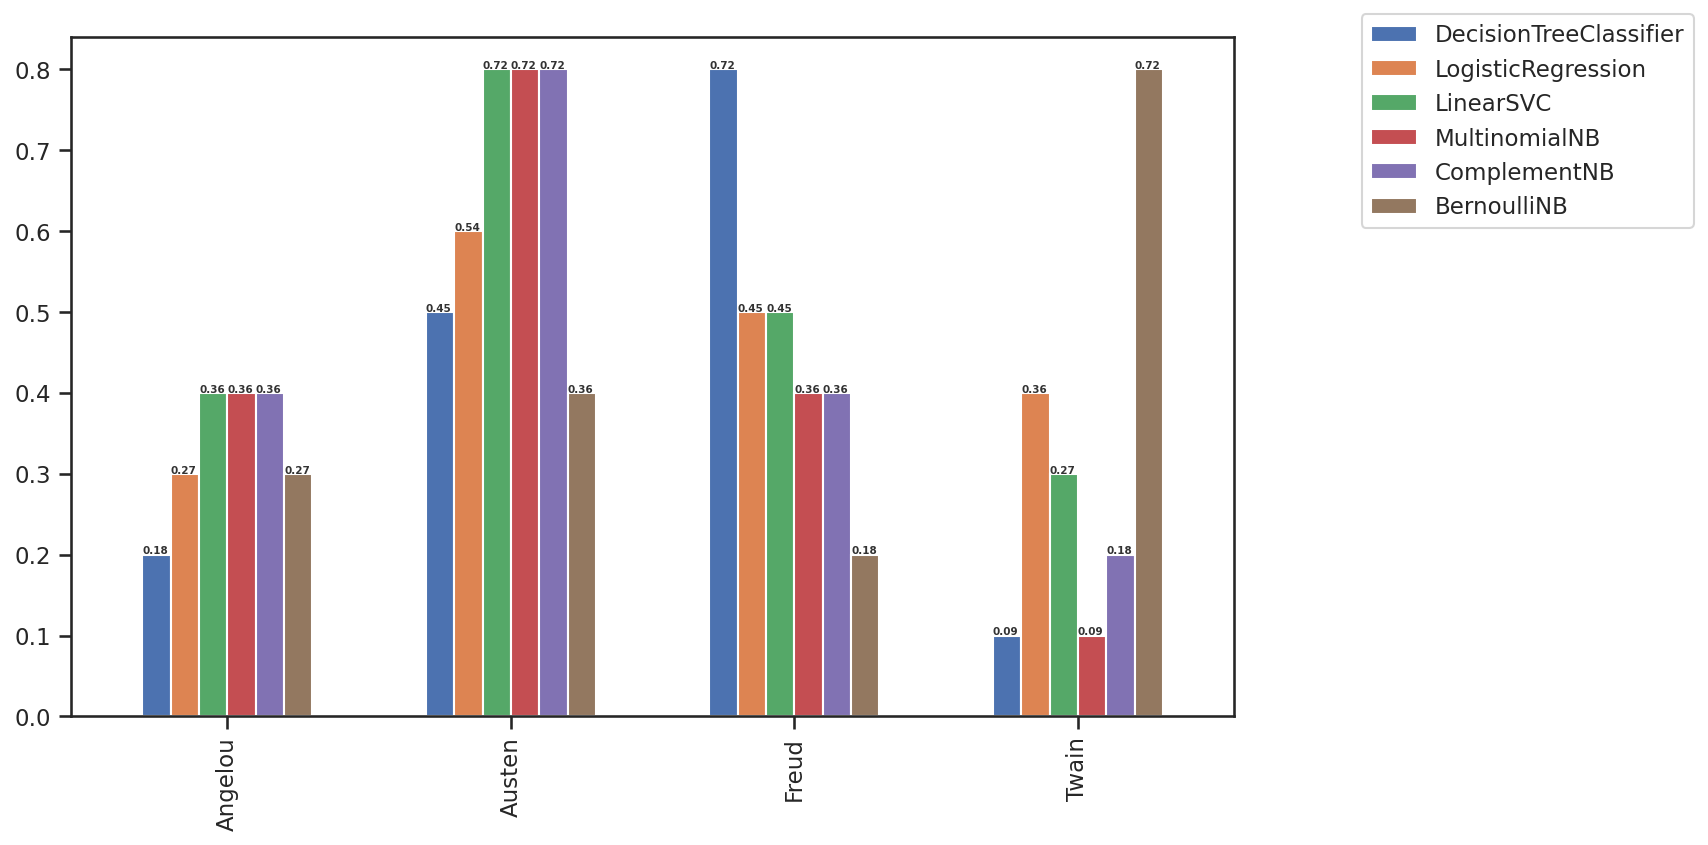

In [42]:
# Графики сранения accuracy для лучших моделей мультиклассовой классификации
print_models_plots(*multi_model_stats)

Как видно из таблицы и диаграмм разные модели предсказали лучше разных авторов:
1. Цитаты Майя Энджелоу были предсказаны хуже всего: максимальный показатель составил 0.36
2. Цитаты Джейн Остин лучше всего предсказали 3 модели:  LinearSVC, MultinomialNB, ComplementNB со значением 0.72
3. Цитаты Зигмунда Фрейда лучше всего предсказала модель DecisionTreeClassifier со значением 0.72
4. Цитаты Марка Твена хорошо предсказал только BernoulliNB со значением 0.72.

В целом, ни одна модель не предсказала все классы с приемлимым качеством. На каждом авторе различные модели проявили себя лучше, чем другие, что связано с особенностью предметной области и размером датасета.

# 9. Выводы
Таким образом, были построены составные модели с учетом особенностей текстовой классификации. Однако из-за небольшого размера исходного датасета реализовать качественные модели не удалось. Возможным решением этой проблемы стало бы использование сторонних моделей и текстовых баз данных.
Несмотря на это, был получен опыт в текстовой классификации с использованием таких инструментов как токенизаторы, векторизаторы, лемматизаторы.